In [44]:
import yfinance as yf
import pandas as pd
from datetime import datetime,timedelta
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from fredapi import Fred


SPY: SPY is the ticker symbol for the SPDR S&P 500 ETF, an ETF that tracks the performance of the S&P 500 Index. It represents a broad selection of large-cap U.S. companies.

BND: BND is the ticker symbol for the Vanguard Total Bond Market ETF, which seeks to track the performance of the Bloomberg Barclays U.S. Aggregate Float Adjusted Index. BND provides exposure to a diversified portfolio of U.S. investment-grade bonds.

GLD: GLD is the ticker symbol for the SPDR Gold Shares ETF. It is designed to track the price of gold bullion and offers investors a way to invest in gold without physically owning it.

QQQ: QQQ is the ticker symbol for the Invesco QQQ Trust, an ETF that tracks the performance of the Nasdaq-100 Index. The index includes 100 of the largest non-financial companies listed on the Nasdaq Stock Market.

VTI: VTI is the ticker symbol for the Vanguard Total Stock Market ETF, which aims to track the performance of the CRSP US Total Market Index. VTI provides exposure to a wide range of U.S. stocks, including large-, mid-, small-, and micro-cap companies.

In [45]:
tickers=["SPY","BND","GLD","QQQ","VTI"]

In [46]:
end_date = datetime.today()
start_date = end_date - timedelta(days=8*365)

In [47]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker,start= start_date,end= end_date)
    adj_close_df[ticker] = data["Adj Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


The resulting log return values will represent the daily percentage changes in the adjusted closing prices of the financial asset or security.

In [48]:
log_return = np.log(adj_close_df/adj_close_df.shift(1))

In [49]:
log_return = log_return.dropna()

252 represents the approximate number of trading days in a year, assuming there are no holidays or weekends.

In [50]:
cov_matrix = log_return.cov()*252
cov_matrix

,SPY,BND,GLD,QQQ,VTI
SPY,0.035301,0.001105,0.000821,0.040216,0.035913
BND,0.001105,0.002957,0.002876,0.001500,0.001185
GLD,0.000821,0.002876,0.019866,0.001517,0.000915
QQQ,0.040216,0.001500,0.001517,0.053027,0.040883
VTI,0.035913,0.001185,0.000915,0.040883,0.036825


In [51]:
def std_dev (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [52]:
def exp_return(weights, log_return):
    return np.sum(log_return.mean()*weights*252)

In [53]:
def sharpe_ratio (weights, log_return, cov_matrix, risk_free_rate):
    return((exp_return(weights, log_return)-risk_free_rate)/std_dev (weights, cov_matrix))

Risk-free rate approximation: The risk-free rate represents the return an investor can expect to earn with certainty, without taking any risk. In practice, no investment is entirely risk-free, but certain government securities, like ten-year Treasury bonds, are considered to be very close to risk-free. These bonds are backed by the U.S. government, which is considered one of the most creditworthy entities in the world. As a result, the ten-year Treasury rate is often used as a practical approximation of the risk-free rate.

Long-term investment horizon: The ten-year Treasury rate is based on ten-year government bonds' yields, which means it represents a longer-term interest rate. The Sharpe Ratio is often used to assess the risk-adjusted performance of investments over extended periods, and using a long-term risk-free rate aligns with this investment horizon.

In [54]:
#risk_free_rate = 0.02 The industry standard is 0.2 

fred = Fred(api_key="9ee5fbf7ac7d254b7ebcaff0633be1e4")
treasury_rate = fred.get_series_latest_release("GS10")/100

risk_free_rate = treasury_rate.iloc[-1]
print(risk_free_rate)

0.0375


Scipy.optimize.minimize() function is being used so we have to find the negative sharpe ration

In [55]:
def neg_sharpe_ratio (weights, log_return, cov_matrix, risk_free_rate):
    return(-sharpe_ratio(weights,log_return,cov_matrix,risk_free_rate))

In [56]:
constraints = {"type": "eq","fun": lambda weights: np.sum(weights)-1}
bounds = [(0,0.4) for _ in range(len(tickers))]

In [57]:
init_weights = np.array([1/len(tickers)]*len(tickers))
print(init_weights)

[0.2 0.2 0.2 0.2 0.2]


SLSQP stands for "Sequential Least Squares Programming," and it is a type of numerical optimization algorithm used to solve constrained nonlinear optimization problems. The SLSQP algorithm is particularly well-suited for problems with both equality and inequality constraints.

In the context of finance and portfolio optimization, SLSQP can be employed to find the optimal weights for different assets in a portfolio. The objective is typically to maximize returns while considering various constraints, such as risk tolerance, target return, and limits on the allocation to individual assets.

The algorithm starts with an initial set of weights and iteratively updates them to find the optimal solution. It employs a combination of gradient-based optimization techniques (utilizing derivatives) and quadratic programming to handle the constraints efficiently.

In [58]:
opti_results = minimize(neg_sharpe_ratio,init_weights,args=(log_return,cov_matrix,risk_free_rate),method="SLSQP", constraints=constraints,bounds=bounds)

print(opti_results)

     fun: -0.5497006289750983
     jac: array([-0.17109872, -0.02211902, -0.24766543, -0.32761501, -0.12439585])
 message: 'Optimization terminated successfully'
    nfev: 30
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([2.00000000e-01, 1.11022302e-16, 4.00000000e-01, 4.00000000e-01,
       5.89805982e-17])


In [59]:
optimal_weights = opti_results.x
print(optimal_weights)

[2.00000000e-01 1.11022302e-16 4.00000000e-01 4.00000000e-01
 5.89805982e-17]


In [60]:
print ("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

print ()

optimal_portfolio_return = exp_return(optimal_weights, log_return)
optimal_portfolio_volatility = std_dev(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_return, cov_matrix, risk_free_rate)

print (f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print (f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.2000
BND: 0.0000
GLD: 0.4000
QQQ: 0.4000
VTI: 0.0000

Expected Annual Return: 0.1155
Expected Volatility: 0.1419
Sharpe Ratio: 0.5497


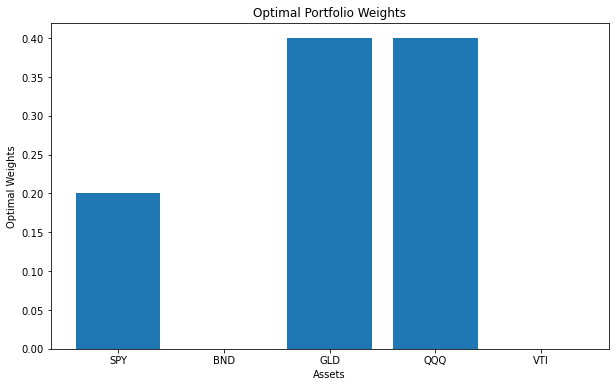

In [61]:
plt.figure(figsize=(10,6))
plt.bar(tickers, optimal_weights)

plt.xlabel("Assets")
plt.ylabel("Optimal Weights")
plt.title("Optimal Portfolio Weights")

plt.show()